# Journal 2022-08-30

In [1]:
%load_ext autoreload
%autoreload 2

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import rax
import cvxpy as cp
import cvxpylayers as cpl 
import flax
import optax
import ipywidgets as widgets

In [4]:
import pandas_datareader as pddr
import tensorflow as tf
import tensorflow.keras as keras

In [10]:
import market_data as mdat
import yfinance as yf

In [9]:
ftse_100 = mdat.Index('FTSE 100')
ftse_100.get()

Reading from cache /home/mattmcd/Work/Data/ftse-100.csv


In [11]:
df_p = yf.download(ftse_100.yfinance_tickers(), period='3y', interval='1d')

[*********************100%***********************]  100 of 100 completed


Calculate weekly Friday to Friday returns and discard any stocks with missing data.  We could have also done this by `pct_change(5)` then downsampling with `last`.  Using `pct_change(1)` to get daily returns and then downsampling with `sum` does not work since simple returns aggregate across stocks not across time (see [Quant Nugget 2: Linear vs. Compounded Returns – Common Pitfalls in Portfolio Management](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1586656))

In [94]:
df_r_w = df_p['Adj Close'].resample('W-FRI').last().pct_change(1).iloc[1:].dropna(axis=1)

In [98]:
df_r_w.shape

(157, 98)

Use the weekly returns to group the stocks into return quantiles. 

NB: 
* we use the negative of returns so that the 0th quantile has the best returning stocks
* we exclude the final week since it will generally be a partial one (could modifiy this)

In [132]:
df_r_q = df_r_w.apply(lambda x: pd.qcut(-x, 5, labels=False), axis=1).iloc[:-1]
df_r_q
# df_r_q.columns[df_r_q.iloc[-1] == 0]

,AAF.L,AAL.L,ABDN.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AVST.L,...,STJ.L,SVT.L,TSCO.L,TW.L,ULVR.L,UTG.L,UU.L,VOD.L,WPP.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-06,4,0,3,1,4,3,0,4,1,4,...,0,4,0,1,4,4,4,3,2,2
2019-09-13,4,0,0,3,2,2,1,2,0,3,...,1,2,1,0,4,2,3,1,1,2
2019-09-20,0,4,2,2,1,3,4,3,4,0,...,4,1,1,1,3,0,1,2,3,2
2019-09-27,4,3,0,3,4,3,3,4,1,4,...,2,0,2,4,1,1,0,1,4,3
2019-10-04,0,2,3,3,0,3,4,3,3,2,...,4,1,2,3,1,0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-29,4,0,1,4,0,0,0,1,2,4,...,1,3,2,3,1,4,2,4,2,4
2022-08-05,4,3,1,3,1,3,1,0,1,0,...,2,2,2,3,2,4,1,1,4,2
2022-08-12,4,1,0,2,0,1,4,3,0,4,...,1,3,3,3,4,0,2,3,3,1


Look at which stocks have consistently been in the top returns quantile from a given start date (higher number = better)

In [293]:
start_date = '2022-03'
(df_r_q.loc[start_date:] == 0).sum().div(len(df_r_q.loc[start_date:])).sort_values(ascending=False)[:10]

SSE.L     0.423077
BA.L      0.423077
FRES.L    0.384615
GLEN.L    0.384615
BP.L      0.346154
STAN.L    0.346154
FLTR.L    0.346154
OCDO.L    0.346154
RS1.L     0.346154
AAL.L     0.307692
dtype: float64

Even these stocks will have had a mix of returns e.g. a couple of bad weeks can take out good returns the rest of the time.  Plot actual full period return rank vs this indicator?

In [266]:
s_ret = df_p['Adj Close'].loc[start_date:].iloc[-1].div(
    df_p['Adj Close'].loc[start_date:].iloc[0]
).sub(1.).dropna()
# Check on how to use argsort - gives index into original array s.t. array[idx] -> sorted(array)
s_ret.sort_values()[:10].equals(s_ret.iloc[s_ret.argsort()].iloc[:10])
#.argsort().sort_values()[:20]

True

In [267]:
s_ret.sort_values(ascending=False)[:10]

PSON.L    0.369462
BP.L      0.341582
LSEG.L    0.318770
SHEL.L    0.247752
AZN.L     0.225917
CCH.L     0.195414
STAN.L    0.188915
IMB.L     0.182605
RS1.L     0.171337
CPG.L     0.170408
dtype: float64

In [289]:
df_s = s_ret.to_frame()
# Use argsort to create sorted ranking, higher = better to match quantile ranking
df_s.loc[s_ret.index[s_ret.argsort()[::-1]], 'sorted_return'] = np.arange(len(df_s))[:, np.newaxis][::-1]
# Add in the sorted quantile rank sum, scaled by number of available periods i.e. if
# a stock was always in the top quantile it would have value 1. 
s_q_sum = (df_r_q.loc[start_date:] == 0).sum()/len(df_r_q.loc[start_date:])
s_q_sum.name = 'sorted_quantile_sum'
df_s = df_s.join(s_q_sum)
df_s.sort_values('sorted_quantile_sum').tail(20)

,0,sorted_return,sorted_quantile_sum
EDV.L,-0.158824,24.0,0.269231
JD.L,-0.232537,10.0,0.269231
SHEL.L,0.247752,94.0,0.307692
CNA.L,0.101882,79.0,0.307692
CCH.L,0.195414,92.0,0.307692
AVV.L,0.156267,87.0,0.307692
AZN.L,0.225917,93.0,0.307692
ANTO.L,-0.233355,9.0,0.307692
AVST.L,0.117766,81.0,0.307692
AAL.L,-0.235156,7.0,0.307692


<AxesSubplot:xlabel='sorted_return', ylabel='sorted_quantile_sum'>

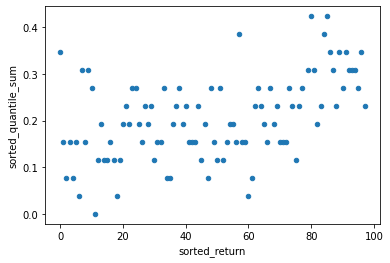

In [290]:
df_s.plot(kind='scatter', x='sorted_return', y='sorted_quantile_sum')

In [292]:
df_s.loc[(df_s.sorted_return > 80) & (df_s.sorted_quantile_sum > 0.25), :].sort_values(0)

,0,sorted_return,sorted_quantile_sum
AVST.L,0.117766,81.0,0.307692
GLEN.L,0.126634,84.0,0.384615
SSE.L,0.139221,85.0,0.423077
FLTR.L,0.143190,86.0,0.346154
AVV.L,0.156267,87.0,0.307692
RS1.L,0.171337,89.0,0.346154
IMB.L,0.182605,90.0,0.269231
STAN.L,0.188915,91.0,0.346154
CCH.L,0.195414,92.0,0.307692
AZN.L,0.225917,93.0,0.307692


In [175]:
def extract_quantile(date, quantiles=5):
    df_r_q = df_r_w.apply(lambda x: pd.qcut(-x, quantiles, labels=False), axis=1)
    cols = df_r_q.columns[df_r_q.loc[date] == 0]
    return df_r_q.loc[:, cols]

In [191]:
def extract_ticker(ticker, quantiles=5):
    df_r_q = df_r_w.apply(lambda x: pd.qcut(-x, quantiles, labels=False), axis=1)
    cols = df_r_q.columns.isin(ticker)
    return df_r_q.loc[:, cols]

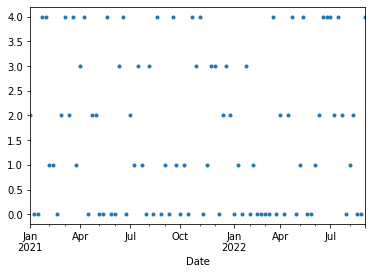

In [199]:
_ = extract_quantile('2022-08-26').loc['2021':, 'GLEN.L'].plot(linestyle='none', marker='.')

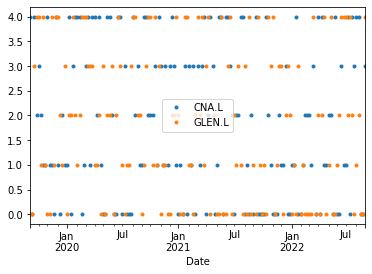

In [205]:
_ = extract_ticker(['CNA.L', 'GLEN.L']).plot(linestyle='none', marker='.')

In [294]:
_ = widgets.interact(
    extract_quantile, 
    date=df_r_w.index.strftime('%Y-%m-%d').tolist()
)

interactive(children=(Dropdown(description='date', options=('2019-09-06', '2019-09-13', '2019-09-20', '2019-09…

Thinking about how to add other signals to a DataFrame with MultiIndex columns.  Can't just use `loc` with new level, so maybe `melt` then concatenate DataFrame with new signals and `pivot` back to MultiIndex now witgh new levels.

In [161]:
df_m = df_p.melt(ignore_index=False, var_name=['field', 'stock'])
df_m.head()

,field,stock,value
Date,,,
2019-08-30,Adj Close,AAF.L,56.981148
2019-09-02,Adj Close,AAF.L,57.704044
2019-09-03,Adj Close,AAF.L,56.981148
2019-09-04,Adj Close,AAF.L,56.173206
2019-09-05,Adj Close,AAF.L,55.790493


In [168]:
df_m.pivot(columns=['field', 'stock'], values='value').head()

field       Adj Close                                                     \
stock           AAF.L        AAL.L      ABDN.L        ABF.L        ADM.L   
Date                                                                       
2019-08-30  56.981148  1557.557007  197.825119  2199.433350  1933.121948   
2019-09-02  57.704044  1564.580200  200.205704  2213.960449  1945.727539   
2019-09-03  56.981148  1556.503662  197.507721  2250.762695  1916.915283   
2019-09-04  56.173206  1596.008789  196.952255  2291.439453  1886.302124   
2019-09-05  55.790493  1611.810791  198.777344  2295.313232  1880.116821   

field                                                                    ...  \
stock             AHT.L      ANTO.L      AUTO.L        AV.L      AVST.L  ...   
Date                                                                     ...   
2019-08-30  2183.545410  772.364807  514.697083  300.776917  349.170776  ...   
2019-09-02  2200.852295  763.267639  515.665283  302.136047  353.948914  ...   
2019-09-03  2177.776611  743.467957  492.428467  299.248047  354.500244  ...   
2019-09-04  2204.698486  767.727051  493.977570  301.881134  343.473755  ...   
2019-09-05  2212.389893  800.047058  499.980469  309.525848  347.516876  ...   

field          Volume                                                          \
stock           STJ.L      SVT.L      TSCO.L        TW.L     ULVR.L     UTG.L   
Date                                                                            
2019-08-30  4055430.0   647494.0  14558489.0  12845503.0  2220524.0  433980.0   
2019-09-02  1156222.0   491620.0  19556089.0   7694985.0  1815867.0  481501.0   
2019-09-03  1418263.0   934364.0  14594971.0  10240695.0  3181885.0  553749.0   
2019-09-04  1641314.0  1321784.0  13392699.0  10837116.0  1974241.0  487573.0   
2019-09-05  2864092.0   847440.0  15108871.0  16100025.0  2821975.0  605292.0   

field                                                   
stock            UU.L       VOD.L      WPP.L     WTB.L  
Date                                                    
2019-08-30  1974587.0  67647215.0  2293509.0  587604.0  
2019-09-02  1677331.0  68760158.0  1896527.0  612771.0  
2019-09-03  2402753.0  87049890.0  1715738.0  667621.0  
2019-09-04  2345208.0  97640275.0  2356710.0  820979.0  
2019-09-05  4254622.0  48348002.0  2153640.0  362567.0  

[5 rows x 600 columns]

In [165]:
df_p.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAF.L', 'AAL.L', 'ABDN.L', 'ABF.L', 'ADM.L', 'AHT.L', 'ANTO.L', 'AUTO.L', 'AV.L', 'AVST.L', 'AVV.L', 'AZN.L', 'BA.L', 'BARC.L', 'BATS.L', 'BDEV.L', 'BKG.L', 'BLND.L', 'BME.L', 'BNZL.L', 'BP.L', 'BRBY.L', 'BT-A.L', 'CCH.L', 'CNA.L', 'CPG.L', 'CRDA.L', 'CRH.L', 'DCC.L', 'DGE.L', 'DPH.L', 'EDV.L', 'ENT.L', 'EXPN.L', 'FLTR.L', 'FRES.L', 'GLEN.L', 'GSK.L', 'HIK.L', 'HL.L', 'HLMA.L', 'HLN.L', 'HSBA.L', 'HWDN.L', 'IAG.L', 'ICP.L', 'IHG.L', 'III.L', 'IMB.L', 'INF.L', 'ITRK.L', 'JD.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'LSEG.L', 'MGGT.L', 'MNDI.L', 'MNG.L', 'MRO.L', 'NG.L', 'NWG.L', 'NXT.L', 'OCDO.L', 'PHNX.L', 'PRU.L', 'PSH.L', 'PSN.L', 'PSON.L', 'REL.L', 'RIO.L', 'RKT.L', 'RMV.L', 'RR.L', 'RS1.L', 'RTO.L', 'SBRY.L', 'SDR.L', 'SGE.L', 'SGRO.L', 'SHEL.L', 'SKG.L', 'SMDS.L', 'SMIN.L', 'SMT.L', 'SN.L', 'SPX.L', 'SSE.L', 'STAN.L', 'STJ.L', 'SVT.L', 'TSCO.L', 'TW.L', 'ULVR.L', 'UTG.L', 'UU.L', 'VOD.L', 'WPP.L', 'WTB.L']])

In [313]:
def calc_returns(df, period=1):
    melt_names = ['field', 'stock']
    melt_args = {'ignore_index': False, 'var_name': melt_names}
    df_m = df.melt(**melt_args)
    df_r = df['Adj Close'].pct_change(period).dropna()
#     df_r['field'] = f'Return_{period}_Days'
#     df_a = pd.concat([df, df_r], axis=0)
#     df_o = df_a.pivot(columns=['field', 'stock'], values='value').copy()
    return df_m, df_r

In [314]:
df_m, df_r = calc_returns(df_p)

Ok, not really working that well.  Probably easier to construct a new returns array, convert columns to MultiIndex and concat horizontally instead of using melt and pivot.

End goal is signals for each stock in a universe all at once then use the n_time x n_stock x n_signal tensor as the input for a model that predicts overall ranking or quantile within a universe.